In [1]:
import numpy as np
import pandas as pd
import random

from trmf import trmf
from synthetic_data import SyntheticData

from Forecast import AutoRegressionModel, NaiveModel, MeanModel
from RollingCV import RollingCV, get_slice

import matplotlib.pyplot as plt
%matplotlib inline

## Synthetic data

In [31]:
N = 16
T = 128
K = 4
lags = [1,8]
L = len(lags)
sigma_w = 0.5
sigma_x = 0.1
sigma_t = 0.0

sd = SyntheticData(N, T, K, lags, sigma_w, sigma_x, sigma_t, seed=2)
sd.synthesize_data()
data = sd.get_data()

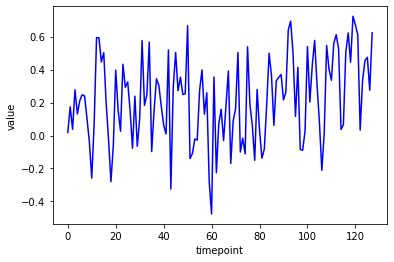

In [32]:
plt.figure()
plt.plot(data[0], color='blue')

plt.xlabel('timepoint')
plt.ylabel('value')

plt.show()

In [34]:
# TRMF model
lambda_f = 1.
lambda_x = 1.
lambda_w = 1.
eta = 1.
alpha = 1000.
max_iter = 5000

model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)

scores_nd = RollingCV(model, data, T-10, 1, T_step=1, metric='ND')
print("ND scores...")
scores_nrmse = RollingCV(model, data, T-10, 1, T_step=1, metric='NRMSE')
print("NRMSE scores...")
scores_mae = RollingCV(model, data, T-10, 1, T_step=1, metric='MAE')
print("MAE scores...")
scores_mse = RollingCV(model, data, T-10, 1, T_step=1, metric='MSE')
print('TRMF performance ND {}, NRMSE: {}, MAE: {}, MSE: {}'.format(round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3), \
                                                                   round(np.array(scores_mae).mean(),3), \
                                                                   round(np.array(scores_mse).mean(),3)))

ND scores...
NRMSE scores...
MAE scores...
TRMF performance ND 0.28, NRMSE: 0.325, MAE: 0.482, MSE: 0.378


## Electricity

In [2]:
electricity = pd.read_table('../data/LD2011_2014.txt', sep=';', decimal=',')
electricity.head()

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# transpose and sum by hours
data = electricity.values[:,1:].T.reshape((35064*370,4)).sum(axis=1).reshape((370,35064))[:,10064:].astype(float)[:, -750:]
data.shape

(370, 750)

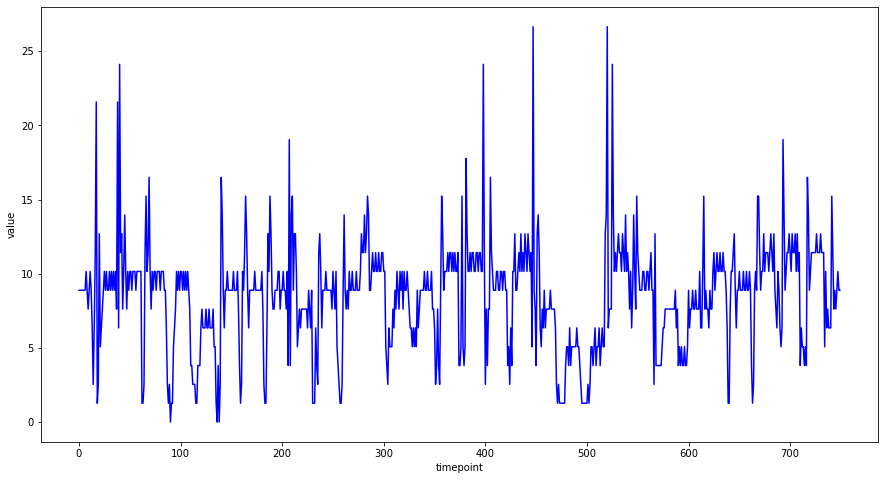

In [4]:
plt.figure(figsize=(15,8))
plt.plot(data[0], color='blue')

plt.xlabel('timepoint')
plt.ylabel('value')

plt.show()

In [5]:
N = 370
T = 750
K = 8
lags = [1, 24]
L = len(lags)

In [6]:
lambda_f = 2.
lambda_x = 2.
lambda_w = 2.
eta = 1.
alpha = 1000.
model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter=1000)

In [7]:
T_start = 396
train, test = get_slice(data, 24*7, 24, T_start)

In [8]:
model.fit(train)

In [9]:
pred = model.predict(24)
abs(pred-test).mean()

0.6794140344250137

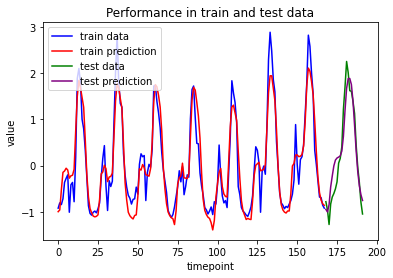

In [12]:
train_preds = np.dot(model.F, model.X)
test_preds = model.predict(24)

idx = 10

plt.figure() # figsize=(15,8)
plt.plot(train[idx], label='train data', color='blue')
plt.plot(train_preds[idx], label='train prediction', color='red')

plt.plot([i+24*7 for i in range(24)], test[idx], label="test data", color="green")
plt.plot([i+24*7 for i in range(24)], test_preds[idx], label="test prediction", color="purple")

plt.title('Performance in train and test data')
plt.xlabel('timepoint')
plt.ylabel('value')

plt.legend(loc="upper left")
# plt.savefig("../report/images/trmf_electricity.png", facecolor="white", bbox_inches="tight")
plt.show()

In [44]:
# TRMF model
lags = [1, 24]
K = 20
lambda_f = 1.
lambda_x = 1.
lambda_w = 1.
eta = 1.
alpha = 1000.
max_iter = 1000

model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)

scores_nd = RollingCV(model, data, 24*7, 24, T_step=12, metric='ND')
print("ND scores...")
scores_nrmse = RollingCV(model, data, T-24*7, 24, T_step=12, metric='NRMSE')
print("NRMSE scores...")
scores_mae = RollingCV(model, data, T-24*7, 24, T_step=12, metric='MAE')
print("MAE scores...")
scores_mse = RollingCV(model, data, T-24*7, 24, T_step=12, metric='MSE')
print('TRMF performance ND {}, NRMSE: {}, MAE: {}, MSE: {}'.format(round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3), \
                                                                   round(np.array(scores_mae).mean(),3), \
                                                                   round(np.array(scores_mse).mean(),3)))

ND scores...
NRMSE scores...
MAE scores...
TRMF performance ND 0.569, NRMSE: 0.917, MAE: 0.63, MSE: 0.851


## Traffic

In [13]:
traffic = pd.read_csv("../data/traffic.txt", header=None)
traffic.rename(lambda x: "r_"+str(x), inplace=True, axis=1)
traffic

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,r_852,r_853,r_854,r_855,r_856,r_857,r_858,r_859,r_860,r_861
0,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,0.0518,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,0.0409,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,0.0386,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,0.0360,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [14]:
data = traffic.values.T
data.shape

(862, 17544)

In [15]:
N = 862
T = 17544
K = 16
lags = [1, 24]
L = len(lags)

In [16]:
lambda_f = 2.
lambda_x = 2.
lambda_w = 2.
eta = 1.
alpha = 1000.
model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter=1000)

In [17]:
T_start = 15000
train, test = get_slice(data, 24*7, 24, T_start)

In [18]:
model.fit(train)

In [19]:
pred = model.predict(24)
abs(pred-test).mean()

0.427603145561517

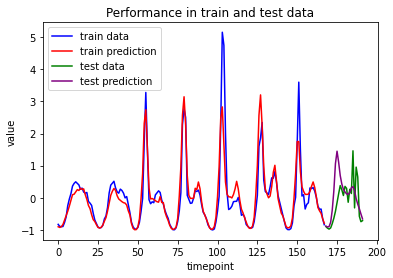

In [20]:
train_preds = np.dot(model.F, model.X)
test_preds = model.predict(24)

idx = 10

plt.figure() # figsize=(15,8)
plt.plot(train[idx], label='train data', color='blue')
plt.plot(train_preds[idx], label='train prediction', color='red')

plt.plot([i+24*7 for i in range(24)], test[idx], label="test data", color="green")
plt.plot([i+24*7 for i in range(24)], test_preds[idx], label="test prediction", color="purple")

plt.title('Performance in train and test data')
plt.xlabel('timepoint')
plt.ylabel('value')

plt.legend(loc="upper left")
#plt.savefig("../report/images/trmf_trafficy.png", facecolor="white", bbox_inches="tight")
plt.show()

In [ ]:
# TRMF model
lags = [1, 24]
K = 20
lambda_f = 1.
lambda_x = 1.
lambda_w = 1.
eta = 1.
alpha = 1000.
max_iter = 1000

model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)

scores_nd = RollingCV(model, data, 24*7, 24, T_step=168, metric='ND')
print("ND scores...")
scores_nrmse = RollingCV(model, data, T-24*7, 24, T_step=168, metric='NRMSE')
print("NRMSE scores...")
scores_mae = RollingCV(model, data, T-24*7, 24, T_step=168, metric='MAE')
print("MAE scores...")
scores_mse = RollingCV(model, data, T-24*7, 24, T_step=168, metric='MSE')

In [30]:
print('TRMF performance ND {}, NRMSE: {}, MAE: {}, MSE: {}'.format(round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3),\
                                                                   round(np.array(scores_mae).mean(),3),\
                                                                   round(np.array(scores_mse).mean(),3)))

TRMF performance ND 0.57, NRMSE: 0.618, MAE: 0.247, MSE: 0.161


## ETT

In [31]:
data = pd.read_csv("../data/ETTh1.csv", sep=",")
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [37]:
# Standardize
numerical = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
column_std = dict()
for num in numerical:
    x = data.loc[:11680, num]
    avg = x.mean()
    std = x.std()
    column_std[num] = {"mean": avg, "std": std}
    data.loc[:11680, num] = (x-avg)/std # train
    data.loc[11680:, num] = (data.loc[11680:, num]-avg)/std # test
del x

In [38]:
train = data[:11680][numerical].values.T
test = data[11680:14600][numerical].values.T

In [39]:
# TRMF model
lags = [1, 2, 3, 4]
K = 100
lambda_f = .5
lambda_x = .5
lambda_w = .5
eta = 1.
alpha = 1000.
max_iter = 1000

model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)

In [40]:
model.fit(train)

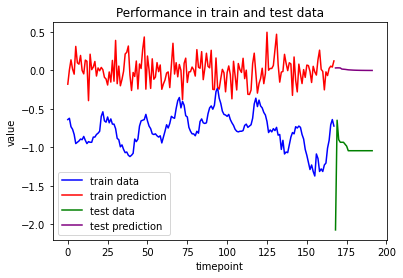

In [41]:
train_preds = np.dot(model.F, model.X)
test_preds = model.predict(24)

idx = 6

plt.figure()
plt.plot(train[idx, -168:], label='train data', color='blue')
plt.plot(train_preds[idx, -168:], label='train prediction', color='red')

plt.plot([i+24*7 for i in range(24)], test[idx, :24], label="test data", color="green")
plt.plot([i+24*7 for i in range(24)], test_preds[idx, :], label="test prediction", color="purple")

plt.title('Performance in train and test data')
plt.xlabel('timepoint')
plt.ylabel('value')

plt.legend(loc="lower left")
#plt.savefig("../report/images/trmf_etth1_norm.png", facecolor="white", bbox_inches="tight")
plt.show()

In [29]:
for h in [24, 48, 168, 336, 720]:
    res = model.predict(h)
    
    print(h)
    print(f"MSE:{((res-test[6, :h])**2).mean()}") #MSE
    print(f"MAE: {abs(res-test[6, :h]).mean()}") #MAE

24
MSE:1.1416517446271404
MAE: 1.042695227762824
48
MSE:0.9407672246775964
MAE: 0.9371247336982427
168
MSE:0.8798237648813739
MAE: 0.9000695502801866
336
MSE:0.8601432412077502
MAE: 0.8989733852548105
720
MSE:1.2541025629945546
MAE: 1.0800695068239838
